In [1]:
import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

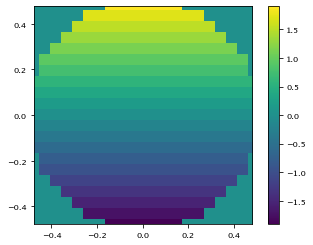

In [2]:
# visualizations of the mode basis elements
imshow_field(zernike(*ansi_to_zernike(1))(make_pupil_grid(21)))
plt.colorbar()

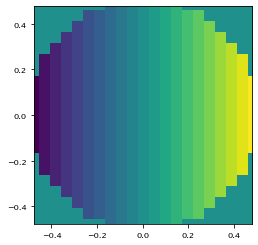

In [3]:
imshow_field(zernike(*ansi_to_zernike(2))(make_pupil_grid(21)))

In [4]:
def pupil(N):

    p = np.zeros([N,N])

    radius = N/2.
    [X,Y] = np.meshgrid(np.linspace(-(N-1)/2.,(N-1)/2.,N),np.linspace(-(N-1)/2.,(N-1)/2.,N))
    R = np.sqrt(pow(X,2)+pow(Y,2))
    p[R<=radius] = 1
    
    return p

def projectOntoDM(Z,nAct,wL):

    # Convert phase to optical path length and halve to
    # compensate for double pass of DM
    Z_DM = Z*wL/(2*np.pi)

    # Set commands only for valid actuators
    p = pupil(nAct)==1

    # Scale commands for Keck DM (1V = 0.6u)
    scale = 0.6e-6
    Z_coefs = Z_DM[p]/scale

    # Remove piston (average)
    #Z_coefs = Z_coefs - np.mean(Z_coefs)

    return Z_coefs

In [5]:
wavelength = 5e-7
dt    = 1/1000
T     = 1
nAct  = 21
D     = 10.95
r0    = 16.5e-2   
k     = 2 * np.pi / wavelength
scale = 0.6e-6
Z_DM = np.zeros([nAct,nAct])
pup  = pupil(nAct) == 1
binning_factor = 8
p = nAct*binning_factor
pupil_grid     = make_pupil_grid(p, D)

times = np.arange(0, T, dt)

## Define Zernike basis set
## We're planning to subtract the first 3 modes: piston, tip, and tilt
mode_basis = make_zernike_basis(num_modes=3, D=D, grid=pupil_grid)
tip = mode_basis[1:2]
tilt = mode_basis[2:3]
g = make_pupil_grid(nAct * binning_factor)
pure_tip, pure_tilt = [zernike(*ansi_to_zernike(i))(g) for i in (1, 2)]

In [6]:
outer_scale   = 20 
wind_velocity = 15
Cn2           = r0**(-5. / 3) / (0.423 * k**2)

def turbulence_onemode(controlled_modes):
    single_layer_atmos = InfiniteAtmosphericLayer(pupil_grid,  Cn_squared=Cn2, L0=outer_scale, 
                                                  velocity=wind_velocity, use_interpolation=True)
    modal_layer = ModalAdaptiveOpticsLayer(layer=single_layer_atmos, controlled_modes=controlled_modes, lag=0)
    single_layer_turb = [None] * times.size
    for n in range(times.size):
        modal_layer.evolve_until(times[n])
        correction = modal_layer.phase_subtraction(wavelength)
        single_layer_turb[n] = Field(correction, grid=g)
    return single_layer_turb

#np.save('./single_layer_turb_volts.npy', single_layer_turb)
turbulence_tip, turbulence_tilt = turbulence_onemode(tip), turbulence_onemode(tilt)

In [7]:
def filter_slopes(slopes):
    # takes out the zeros by interpolating linearly
    def try_interp(t):
        valid_ind = np.argwhere(slopes != 0.0)
        try:
            return interp1d(times[valid_ind].flatten(), slopes[valid_ind].flatten())(t)
        except ValueError:
            return slopes[np.argwhere(times == t)]
    return np.vectorize(try_interp)(times)

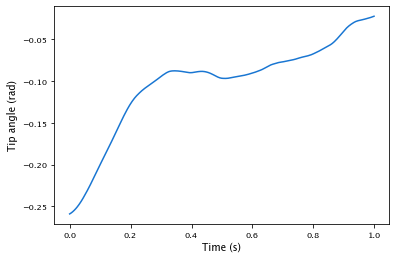

In [8]:
slopes_tip = np.zeros(times.size)
for i, f in enumerate(turbulence_tip):
    grad = np.gradient(f.reshape(p,p), axis=1).flatten() 
    # flat version is a valid hcipy Field that you can imshow_field
    # also, only take grad along axis 1 (y dimension) because that's where the small deviations are
    slopes_tip[i] = grad[np.argmin(np.abs(grad[grad != 0]))] 
    # should ideally have this as applying the mask instead of just discarding the zeros
plt.plot(times, filter_slopes(slopes_tip))
plt.xlabel("Time (s)")
plt.ylabel("Tip angle (rad)")
plt.show()

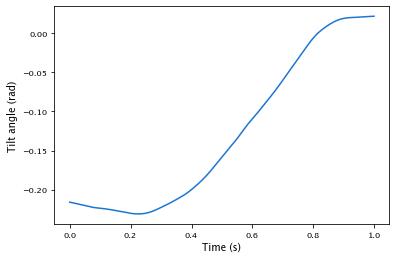

In [9]:
slopes_tilt = np.zeros(times.size)
for i, f in enumerate(turbulence_tilt):
    grad = np.gradient(f.reshape(p,p), axis=0).flatten()
    slopes_tilt[i] = grad[np.argmin(np.abs(grad[grad != 0]))]
plt.plot(times, filter_slopes(slopes_tilt))
plt.xlabel("Time (s)")
plt.ylabel("Tilt angle (rad)")
plt.show()